In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Loading dataset

In [ ]:
# %cd drive/MyDrive/NLP_Project/project+/
# !ls

In [1]:
!nvidia-smi

Sun Sep  4 17:25:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2) Importing libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

In [4]:
aggressions = load_dataset('csv', data_files={'train': 'total_TRAC.csv'
                                              })
print(aggressions)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-aaa117e058bd38d4/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Category'],
        num_rows: 12244
    })
})


In [5]:
train_ds = aggressions['train']
train_ds

Dataset({
    features: ['Sentence', 'Category'],
    num_rows: 12244
})

## 3) Converting to dataframe

In [6]:
aggressions.set_format(type='pandas')
df = aggressions['train'][:]
df.head()

,Sentence,Category
0,Now u will see the reaction which have never b...,CAG
1,printing new notes cost money and those banned...,CAG
2,Sonu is a jobless singer now...So his desperat...,OAG
3,That moron who said **bevkoof hai Jo support k...,NAG
4,Good neus,NAG


In [7]:
df['Category'].value_counts()

NAG    5436
CAG    4093
OAG    2715
Name: Category, dtype: int64

In [ ]:
# 12244
# NAG-CAG-OAG = 0.44-0.33-0.23

In [8]:
# Label encoding
dt = {'NAG':0, 'CAG':1, 'OAG':2}
df['Category'].unique()
labels = map(lambda x: dt[x], df['Category'])
labels = list(labels)
labels = pd.Series(labels)

df['Label'] = labels
labs = np.array(labels)
df.head(5)

,Sentence,Category,Label
0,Now u will see the reaction which have never b...,CAG,1
1,printing new notes cost money and those banned...,CAG,1
2,Sonu is a jobless singer now...So his desperat...,OAG,2
3,That moron who said **bevkoof hai Jo support k...,NAG,0
4,Good neus,NAG,0


Seeing Distribution

In [9]:
disb_df = df.copy(deep=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


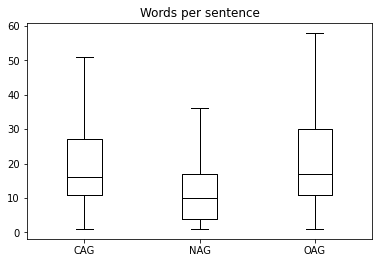

In [10]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Category', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [11]:
from transformers import AutoTokenizer

In [12]:
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
tokenizer.vocab_size

30522

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
texts = list(df['Sentence'])
labels = list(df['Label'])

## 5) Splitting into train-valid-test

In [16]:
train_size=0.8

# In the first step we will split the data in training and remaining dataset
train_texts, X_rem, train_labels, y_rem = train_test_split(texts, labels, train_size=0.8, random_state=43)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
valid_texts, test_texts, valid_labels, test_labels = train_test_split(X_rem, y_rem, test_size=0.5, random_state=43)

print(str(np.shape(train_texts))), print(str(np.shape(train_labels)))
print(str(np.shape(valid_texts))), print(str(np.shape(valid_labels)))
print(str(np.shape(test_texts))), print(str(np.shape(test_labels)))


(9795,)
(9795,)
(1224,)
(1224,)
(1225,)
(1225,)


(None, None)

In [17]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [18]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [20]:
import torch

In [ ]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [32]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [23]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [25]:
from transformers import Trainer, TrainingArguments

In [27]:
# Defining hyperparameters

logging_steps = len(train_texts) // 16
model_name = f"{model_ckpt}-finetuned-TRAC"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2.824279936868144e-05,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  weight_decay=0.17327236865873835,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='error', 
                                  report_to="wandb", 
                                  run_name="bert-base-Trac-DS")

In [ ]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [28]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.20, 0.33, 0.47]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [30]:
from transformers import EarlyStoppingCallback

In [33]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        callbacks = [EarlyStoppingCallback(early_stopping_patience = 1, early_stopping_threshold=0.001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


wandb: Currently logged in as: sky-s-the-limit. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
612,0.835400,0.732269,0.693627,0.683454,0.663180,0.666683
1224,0.592500,0.719134,0.696895,0.677048,0.684614,0.677489
1836,0.361000,1.047448,0.710784,0.688107,0.682263,0.684513
2448,0.202400,1.257414,0.705882,0.685657,0.685433,0.684513


eval/accuracy,▁▂█▆
eval/f1,▁▅██
eval/loss,▁▁▅█
eval/precision,▅▁█▆
eval/recall,▁█▇█
eval/runtime,▇▁█▇
eval/samples_per_second,▂█▁▂
eval/steps_per_second,▂█▁▁
train/epoch,▁▁▃▃▆▆███
train/global_step,▁▁▃▃▆▆███
train/learning_rate,█▆▃▁


In [34]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
trainer.push_to_hub(repo_name="Finetuned-AD-TRAC-BERT")

## 8) Predictions and Results

In [36]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [37]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [38]:
preds_output_test = trainer.predict(test_dataset)

In [39]:
preds_output_test.metrics

{'test_loss': 1.3140766620635986,
 'test_accuracy': 0.689795918367347,
 'test_precision': 0.6692799922120937,
 'test_recall': 0.6711405900355817,
 'test_f1': 0.6683757280319464,
 'test_runtime': 20.2795,
 'test_samples_per_second': 60.406,
 'test_steps_per_second': 3.797}

In [40]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [41]:
y_valid_test = np.array(test_dataset.labels)

In [42]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [43]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.86      0.76      0.81       548
         CAG       0.60      0.66      0.63       404
         OAG       0.55      0.59      0.57       273

    accuracy                           0.69      1225
   macro avg       0.67      0.67      0.67      1225
weighted avg       0.70      0.69      0.69      1225



In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

cm = confusion_matrix(y_valid_test, y_preds_test)

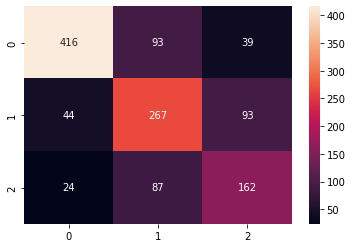

In [45]:
f = sns.heatmap(cm, annot=True, fmt='d')